In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [7]:
with open('../data/crypto_currency.pickle', 'rb') as f:
    data = pickle.load(f)

In [13]:
bch = data['KRW-BCH']

In [14]:
bch.tail()

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate,MA5,MA20,MA60
4,KRW-BCH,2022-02-24T00:00:00,2022-02-24T09:00:00,352300.0,379000.0,323600.0,367650.0,1645747199207,8.029089e+09,23267.777661,352300.0,15350.0,0.043571,359090.0,390880.0,424878.333333
3,KRW-BCH,2022-02-25T00:00:00,2022-02-25T09:00:00,367600.0,380000.0,355200.0,375550.0,1645833586993,7.984606e+09,21774.066608,367650.0,7900.0,0.021488,359940.0,390040.0,421752.500000
2,KRW-BCH,2022-02-26T00:00:00,2022-02-26T09:00:00,376550.0,394450.0,375000.0,385700.0,1645919998296,6.230191e+09,16146.272517,375550.0,10150.0,0.027027,367530.0,389487.5,419204.166667
1,KRW-BCH,2022-02-27T00:00:00,2022-02-27T09:00:00,385650.0,392500.0,369900.0,373350.0,1646006345573,4.344263e+09,11391.337979,385700.0,-12350.0,-0.032020,370910.0,387175.0,416618.333333
0,KRW-BCH,2022-02-28T00:00:00,2022-02-28T09:00:00,374150.0,409800.0,369900.0,409800.0,1646092799255,6.255986e+09,16031.685968,373350.0,36450.0,0.097630,382410.0,387220.0,414701.666667


In [17]:
bch.set_index('candle_date_time_kst', inplace = True)

Text(0, 0.5, 'price')

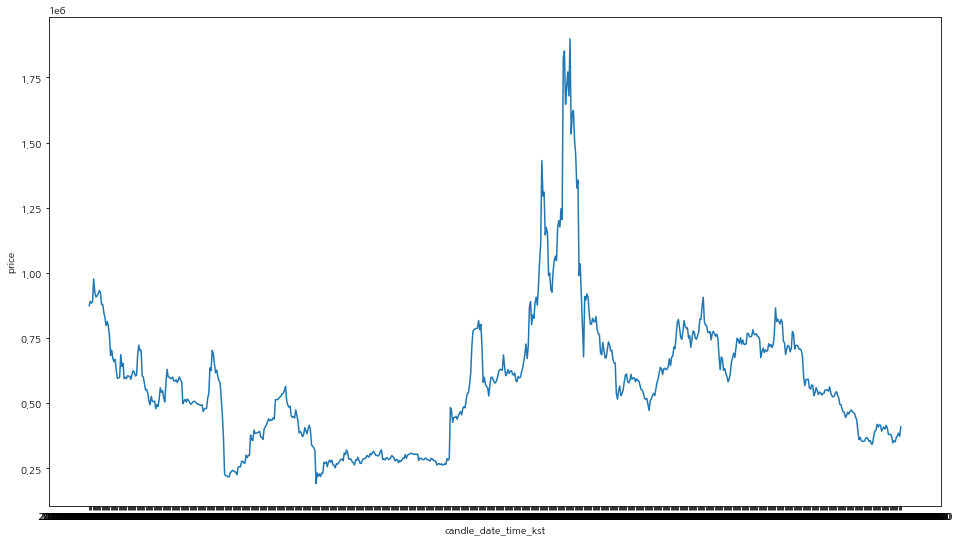

In [22]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=bch['trade_price'], x=bch.index)
plt.xlabel('candle_date_time_kst')
plt.ylabel('price')

In [82]:
scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['trade_price']
# 스케일 후 columns
scaled = scaler.fit_transform(bch[scale_cols])

In [83]:
bch.columns

Index(['market', 'candle_date_time_utc', 'opening_price', 'high_price',
       'low_price', 'trade_price', 'timestamp', 'candle_acc_trade_price',
       'candle_acc_trade_volume', 'prev_closing_price', 'change_price',
       'change_rate', 'MA5', 'MA20', 'MA60'],
      dtype='object')

In [84]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [85]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('trade_price', 1), df['trade_price'], test_size=0.2, random_state=0, shuffle=False)

In [86]:
y_train.head()

0    0.399812
1    0.409778
2    0.405675
3    0.408254
4    0.460077
Name: trade_price, dtype: float64

In [87]:
x_test.head()

""
576
577
578
579
580


In [88]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [89]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [90]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [92]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [93]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [94]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
     16/Unknown - 2s 11ms/step - loss: 0.0352 - mse: 0.0704
Epoch 1: val_loss improved from inf to 0.01235, saving model to tmp/ckeckpointer.ckpt
18/18 [==============================] - 3s 50ms/step - loss: 0.0348 - mse: 0.0696 - val_loss: 0.0123 - val_mse: 0.0247
Epoch 2/50
17/18 [===========================>..] - ETA: 0s - loss: 0.0152 - mse: 0.0303
Epoch 2: val_loss improved from 0.01235 to 0.00190, saving model to tmp/ckeckpointer.ckpt
18/18 [==============================] - 0s 16ms/step - loss: 0.0151 - mse: 0.0301 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 3/50
16/18 [=========================>....] - ETA: 0s - loss: 0.0061 - mse: 0.0123
Epoch 3: val_loss did not improve from 0.00190
18/18 [==============================] - 0s 15ms/step - loss: 0.0060 - mse: 0.0120 - val_loss: 0.0023 - val_mse: 0.0046
Epoch 4/50
16/18 [=========================>....] - ETA: 0s - loss: 0.0043 - mse: 0.0086
Epoch 4: val_loss improved from 0.00190 to 0.00098, saving model to tmp/ckeckpo

In [95]:
model.load_weights(filename)

In [96]:
pred = model.predict(test_data)

In [97]:
pred.shape

(124, 1)

## Plot result

In [98]:
y_test.shape

(144,)

In [99]:
pred_plot = np.concatenate((np.expand_dims(y_train, axis = 1), np.zeros((20, 1)), pred))

In [100]:
pred_plot = scaler.inverse_transform(pred_plot)

In [107]:
actual_plot = np.expand_dims(np.concatenate((y_train, y_test)), axis = 1)

In [108]:
actual_plot = scaler.inverse_transform(actual_plot)

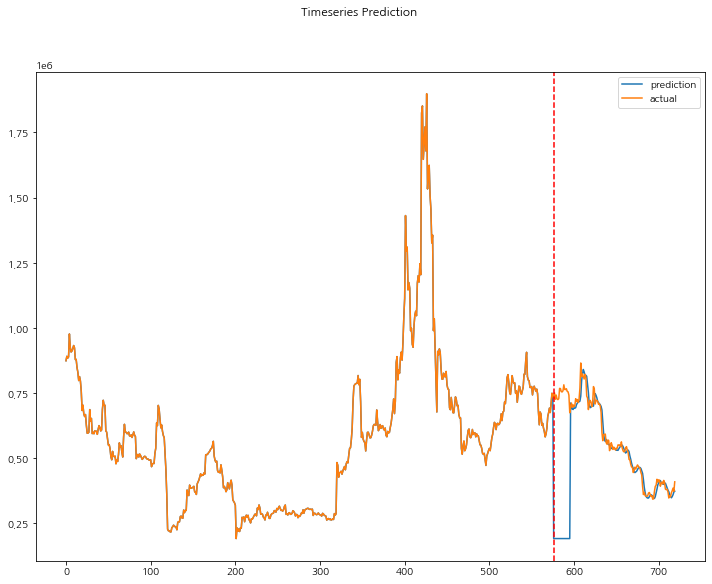

In [109]:
plt.figure(figsize=(12, 9))
plt.plot(pred_plot, label='prediction')
plt.plot(actual_plot, label='actual')
plt.axvline(x = y_train.shape[0], c = 'r', linestyle = '--')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show()